In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('data_with_blunder.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data_with_blunder.csv'

In [ ]:
import numpy as np
def fen_to_array(fen: str):
    board, turn, castling = fen.split()[0], fen.split()[1], fen.split()[2]
    board_array = np.zeros((8, 8, 17), dtype=int)

    piece_map = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }

    row_idx = 0
    for row in board.split('/'):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece_idx = piece_map[char]
                board_array[row_idx, col_idx, piece_idx] = 1
                col_idx += 1
        row_idx += 1

    white_king_castle = 1 if 'K' in castling else 0
    white_queen_castle = 1 if 'Q' in castling else 0
    black_king_castle = 1 if 'k' in castling else 0
    black_queen_castle = 1 if 'q' in castling else 0

    board_array[:, :, 12] = white_king_castle
    board_array[:, :, 13] = white_queen_castle
    board_array[:, :, 14] = black_king_castle
    board_array[:, :, 15] = black_queen_castle

    board_array[:, :, 16] = 1 if turn == 'w' else 0

    return board_array

In [ ]:
gameid = []
id_count = 0
prev = 0
for id, row in data.iterrows():
  if(row['move_number'] < prev):
    id_count += 1
  prev = row['move_number']
  gameid.append(id_count)


In [ ]:
data_set = {
    'game_id' : gameid,
    'board_info' : data['board_position'].apply(fen_to_array),
    'move_number' : data['move_number'],
    'next_move_blunder' : data['next_move_blunder'],
    'increment_code' : data['increment_code'],
    'average_rating' : data['average_rating']
}
data_set = pd.DataFrame.from_dict(data_set)
data_set = pd.get_dummies(data_set, columns=['increment_code'], drop_first=False)
data_set

,game_id,board_info,move_number,next_move_blunder,average_rating,increment_code_10+0,increment_code_10+5,increment_code_15+10
0,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1...",1,False,1578.5,False,False,True
1,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1...",2,False,1578.5,False,False,True
2,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1...",3,False,1578.5,False,False,True
3,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1...",4,False,1578.5,False,False,True
4,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1...",5,False,1578.5,False,False,True
...,...,...,...,...,...,...,...,...
110068,2181,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",50,False,1656.5,False,False,True
110069,2181,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",51,True,1656.5,False,False,True
110070,2181,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",52,True,1656.5,False,False,True
110071,2181,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",53,True,1656.5,False,False,True


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChessFeatureExtractor(nn.Module):
    def __init__(self, extra_input_size=3, feature_dim=256):
        """
        Optimized for speed by reducing layer sizes.
        """
        super(ChessFeatureExtractor, self).__init__()

        # CNN with fewer channels
        self.conv1 = nn.Conv2d(in_channels=17, out_channels=16, kernel_size=3, padding=1)  # 8x8 -> 8x8
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # 8x8 -> 8x8
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 8x8 -> 8x8

        # Fully connected layer for CNN output
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Reduced size

        # Fully connected layer for additional inputs
        self.fc_extra = nn.Linear(extra_input_size, 32)  # Reduced size

        # Combined FC layers
        self.fc2 = nn.Linear(256 + 32, feature_dim)  # Kept final feature_dim same

    def forward(self, board_input, extra_input):
        """
        Forward pass with reduced layers for efficiency.
        """
        x = F.relu(self.conv1(board_input))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))

        extra_features = F.relu(self.fc_extra(extra_input))
        combined_features = torch.cat((x, extra_features), dim=1)

        output_features = self.fc2(combined_features)
        return output_features

# Example usage
model = ChessFeatureExtractor(extra_input_size=3, feature_dim=256)
board_input = torch.randn(1, 17, 8, 8)
extra_input = torch.tensor([[2200, 2300, 5.0]])

features = model(board_input, extra_input)
print(features.shape)

torch.Size([1, 256])


In [ ]:
# # Define the loss function (Binary Cross-Entropy Loss for binary classification)
# criterion = nn.BCELoss()

# # Define the optimizer (Adam optimizer)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# # # Train the model
# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode

#     running_loss = 0.0
#     correct = 0
#     total = 0

#     # Iterate over the training data
#     for inputs, labels in train_loader:
#         # Zero the parameter gradients
#         optimizer.zero_grad()
#         # Forward pass
#         outputs = model(inputs).squeeze()  # Remove extra dimension from the output (convert from (batch_size, 1) to (batch_size,))

#         # Compute the loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Update statistics
#         running_loss += loss.item()

#         # Get predictions (consider any output greater than 0.5 as True)
#         predicted = (outputs > 0.5).float()
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     epoch_loss = running_loss / len(train_loader)
#     epoch_accuracy = correct / total

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
# from sklearn.metrics import f1_score

# # Evaluate the model on the test set using F1 score
# model.eval()  # Set the model to evaluation mode

# true_labels = []
# predicted_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs).squeeze()  # Remove extra dimension from output
#         predicted = (outputs > 0.5).float()  # Apply threshold of 0.5 for binary classification

#         true_labels.extend(labels.cpu().numpy())  # Collect the true labels (convert to numpy for f1_score)
#         predicted_labels.extend(predicted.cpu().numpy())  # Collect the predicted labels (convert to numpy for f1_score)

# # Calculate F1 score
# f1 = f1_score(true_labels, predicted_labels)

# print(f"F1 Score: {f1:.4f}")

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# Initialize model
model = ChessFeatureExtractor(extra_input_size=5, feature_dim=256)

def cnn_transform(row):
    """Transform a row into model features."""
    # Load and process board representation
    board_input = torch.tensor(np.array(row['board_info'], dtype=np.float32)).view(1, 17, 8, 8)

    # Extract extra input features
    extra_columns = ['move_number', 'average_rating', 'increment_code_10+0',
                     'increment_code_10+5', 'increment_code_15+10']
    extra_input = torch.tensor(row.loc[extra_columns].astype(np.float32).values, dtype=torch.float32).view(1, -1)

    # Pass through model
    features = model(board_input, extra_input)

    # Detach from computation graph and convert to NumPy
    return features.detach().numpy()

# Apply transformation with progress bar
tqdm.pandas()  # Enable tqdm for pandas
modif_data = {
    'feature': data_set.progress_apply(lambda row: cnn_transform(row), axis=1),
    'result': data_set['next_move_blunder']
}

# Convert to DataFrame
modif_data = pd.DataFrame.from_dict(modif_data)
modif_data.head()


100%|██████████| 110073/110073 [03:18<00:00, 553.79it/s]


,feature,result
0,"[[89.97874, 21.085894, 43.290955, -10.566993, ...",False
1,"[[89.9753, 21.076609, 43.274837, -10.625604, -...",False
2,"[[89.97334, 21.07689, 43.25677, -10.68196, -23...",False
3,"[[89.96976, 21.067316, 43.239605, -10.7408495,...",False
4,"[[89.9671, 21.066916, 43.221798, -10.797147, -...",False


In [ ]:
modif_data['game_id'] = data_set['game_id']

In [ ]:
modif_data

,feature,result,game_id
0,"[[89.97874, 21.085894, 43.290955, -10.566993, ...",False,0
1,"[[89.9753, 21.076609, 43.274837, -10.625604, -...",False,0
2,"[[89.97334, 21.07689, 43.25677, -10.68196, -23...",False,0
3,"[[89.96976, 21.067316, 43.239605, -10.7408495,...",False,0
4,"[[89.9671, 21.066916, 43.221798, -10.797147, -...",False,0
...,...,...,...
110068,"[[94.15969, 21.805185, 44.528088, -13.841911, ...",False,2181
110069,"[[94.14612, 21.79616, 44.50854, -13.890248, -2...",True,2181
110070,"[[94.13189, 21.779737, 44.483444, -13.944224, ...",True,2181
110071,"[[94.11951, 21.773531, 44.464294, -13.994567, ...",True,2181


In [ ]:
def flatten_board(board):
  return board.flatten()

flattened_boards = modif_data['feature'].apply(flatten_board)
flattened_df = pd.DataFrame(flattened_boards.tolist())
flattened_df = flattened_df.reset_index(drop=True)
clean_data = modif_data.reset_index(drop=True)
flattened_df.columns = ['conv_dim_' + str(col) for col in flattened_df.columns]
clean_data = pd.concat([flattened_df, clean_data.drop(columns=['feature'])], axis=1)
clean_data


,conv_dim_0,conv_dim_1,conv_dim_2,conv_dim_3,conv_dim_4,conv_dim_5,conv_dim_6,conv_dim_7,conv_dim_8,conv_dim_9,...,conv_dim_248,conv_dim_249,conv_dim_250,conv_dim_251,conv_dim_252,conv_dim_253,conv_dim_254,conv_dim_255,result,game_id
0,89.978737,21.085894,43.290955,-10.566993,-23.320726,-33.607292,62.167294,-30.548109,-48.455147,15.337698,...,-15.574970,-95.918396,-64.378189,51.818771,-32.100761,-31.007469,-6.260537,-7.512699,False,0
1,89.975304,21.076609,43.274837,-10.625604,-23.231659,-33.602043,62.168186,-30.546494,-48.434864,15.354659,...,-15.612078,-95.934845,-64.346588,51.850571,-32.082756,-30.977249,-6.221456,-7.552253,False,0
2,89.973343,21.076891,43.256771,-10.681960,-23.150925,-33.590801,62.171967,-30.549019,-48.411209,15.370537,...,-15.650393,-95.952263,-64.307404,51.876705,-32.069077,-30.957527,-6.190068,-7.591068,False,0
3,89.969757,21.067316,43.239605,-10.740849,-23.060469,-33.585571,62.173294,-30.547676,-48.390293,15.386683,...,-15.688066,-95.968742,-64.275940,51.908730,-32.051041,-30.927944,-6.150723,-7.630886,False,0
4,89.967102,21.066916,43.221798,-10.797147,-22.980791,-33.573555,62.176781,-30.551006,-48.366581,15.402884,...,-15.725871,-95.985657,-64.236732,51.933674,-32.037804,-30.908867,-6.119855,-7.670646,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110068,94.159691,21.805185,44.528088,-13.841911,-20.282211,-34.858646,65.129471,-32.145000,-49.974590,16.763113,...,-18.128954,-101.580688,-65.798164,55.813831,-32.752991,-31.207546,-4.961457,-9.632084,False,2181
110069,94.146118,21.796160,44.508541,-13.890248,-20.193853,-34.848293,65.108727,-32.152863,-49.968399,16.766882,...,-18.162872,-101.606171,-65.756371,55.840000,-32.722794,-31.175053,-4.940076,-9.657139,True,2181
110070,94.131889,21.779737,44.483444,-13.944224,-20.108091,-34.842590,65.094254,-32.155216,-49.965515,16.772850,...,-18.193798,-101.631554,-65.720406,55.873943,-32.694881,-31.140347,-4.910001,-9.682137,True,2181
110071,94.119507,21.773531,44.464294,-13.994567,-20.018864,-34.832779,65.074821,-32.163071,-49.959484,16.776514,...,-18.228750,-101.656677,-65.679237,55.899872,-32.665894,-31.108204,-4.889421,-9.706535,True,2181


In [ ]:
from sklearn.model_selection import train_test_split
unique_game_ids = clean_data['game_id'].unique()
train_game_ids, test_game_ids = train_test_split(unique_game_ids, test_size=0.3, random_state=42)
train_data = clean_data[clean_data['game_id'].isin(train_game_ids)]
test_data = clean_data[clean_data['game_id'].isin(test_game_ids)]

In [ ]:
X_train = train_data.drop(columns=['result','game_id'])
X_test = test_data.drop(columns=['result','game_id'])
y_train = train_data['result']
y_test = test_data['result']

F1 Score (Training Data): 0.1988
F1 Score (Testing Data): 0.1946

Confusion Matrix (Training Data):
[[35032 35623]
 [ 1718  4632]]

Confusion Matrix (Testing Data):
[[14970 15335]
 [  812  1951]]


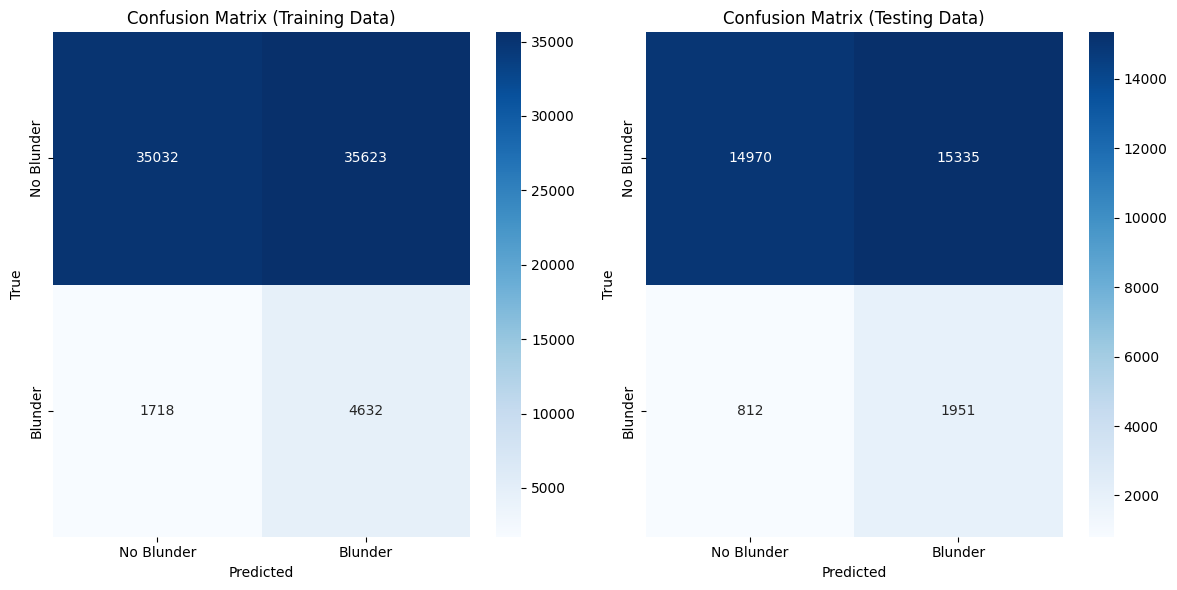

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Train Logistic Regression (for classification)
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


# Step 4: Make predictions on both training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Step 5: Evaluate the model using F1 Score for both training and testing data
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Step 6: Compute confusion matrix for both training and testing data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Print F1 Scores
print(f"F1 Score (Training Data): {f1_train:.4f}")
print(f"F1 Score (Testing Data): {f1_test:.4f}")

# Print Confusion Matrices
print("\nConfusion Matrix (Training Data):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_test)

# Step 7: Visualize the confusion matrices using seaborn heatmap
# Training confusion matrix heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Blunder', 'Blunder'], yticklabels=['No Blunder', 'Blunder'])
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Testing confusion matrix heatmap
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Blunder', 'Blunder'], yticklabels=['No Blunder', 'Blunder'])
plt.title('Confusion Matrix (Testing Data)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For heatmap visualization

# Create the Random Forest model with regularization to combat overfitting
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=200,            # More trees (optional, increases model stability)
    max_depth= 5,                # Limiting the depth of trees to prevent overfitting
    min_samples_split=2,        # Minimum number of samples required to split a node
    min_samples_leaf=1,          # Minimum number of samples required to be in a leaf node
    max_features=0.9,         # Randomly select a subset of features for each split
    class_weight='balanced',     # Use class weights for imbalanced classes
    n_jobs=-1                    # Use all CPU cores to speed up training
)

# Best Hyperparameters Found:  {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# Step 3: Train the model on the training data
rf_model.fit(X_train, y_train)

# Step 4: Make predictions on both training and testing data
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model using F1 Score for both training and testing data
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Step 6: Compute confusion matrix for both training and testing data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Print F1 Scores
print(f"F1 Score (Training Data): {f1_train:.4f}")
print(f"F1 Score (Testing Data): {f1_test:.4f}")

# Print Confusion Matrices
print("\nConfusion Matrix (Training Data):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_test)

# Step 7: Visualize the confusion matrices using seaborn heatmap
# Training confusion matrix heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Blunder', 'Blunder'], yticklabels=['No Blunder', 'Blunder'])
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Testing confusion matrix heatmap
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Blunder', 'Blunder'], yticklabels=['No Blunder', 'Blunder'])
plt.title('Confusion Matrix (Testing Data)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

time series

In [ ]:
def reshape_board_info(df):
    def reshape_for_game(game_df):
        reshaped_boards = []
        for i in range(len(game_df)):
            boards = []
            if i < 4:
              for j in range(4 - i):
                boards.append(np.zeros_like(game_df.iloc[0]['board_info']))
              for j in range(i + 1):
                boards.append(game_df.iloc[j]['board_info'])
            else:
              boards = [game_df.iloc[j]['board_info'] for j in range(max(0, i - 4), i + 1)]
            stacked_boards = np.stack(boards, axis=-1)  # Shape will be (8, 8, 17, 5)
            reshaped_boards.append(stacked_boards)
        return pd.Series(reshaped_boards, index=game_df.index)

    # Apply the reshaping to the board_info column for each game
    reshaped_board_info = df.groupby('game_id', group_keys=False).apply(reshape_for_game)

    # Assign the reshaped 'board_info' column back to the original dataframe
    df['board_info'] = reshaped_board_info.values

    return df
time_data_set = pd.DataFrame(data_set)

time_data_set = reshape_board_info(time_data_set)

time_data_set.head()

<ipython-input-17-b4ccc08df495>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reshaped_board_info = df.groupby('game_id', group_keys=False).apply(reshape_for_game)


,game_id,board_info,move_number,next_move_blunder,average_rating,increment_code_10+0,increment_code_10+5,increment_code_15+10
0,0,"[[[[0 0 0 0 0], [0 0 0 0 0], [0 0 0 0 0], [0 0...",1,False,1578.5,False,False,True
1,0,"[[[[0 0 0 0 0], [0 0 0 0 0], [0 0 0 0 0], [0 0...",2,False,1578.5,False,False,True
2,0,"[[[[0 0 0 0 0], [0 0 0 0 0], [0 0 0 0 0], [0 0...",3,False,1578.5,False,False,True
3,0,"[[[[0 0 0 0 0], [0 0 0 0 0], [0 0 0 0 0], [0 0...",4,False,1578.5,False,False,True
4,0,"[[[[0 0 0 0 0], [0 0 0 0 0], [0 0 0 0 0], [0 0...",5,False,1578.5,False,False,True


In [3]:
import pandas as pd
import numpy as np
import zlib
import pickle
def compress_array(arr):
    # Pickle the numpy array and then compress it
    return zlib.compress(pickle.dumps(arr))
time_data_set['board_info'] = time_data_set['board_info'].apply(compress_array)
time_data_set.to_pickle('compressed_df.pkl')


NameError: name 'time_data_set' is not defined

In [4]:
import pandas as pd
import numpy as np
import zlib
import pickle
def decompress_array(compressed_data):
    # Decompress and then unpickle the data
    return pickle.loads(zlib.decompress(compressed_data))
# time_data_set = pd.read_csv('time_data.csv')
time_data_set = pd.read_pickle('compressed_df.pkl')
time_data_set['board_info'] = time_data_set['board_info'].apply(decompress_array)
print(time_data_set['board_info'][0].shape)  # Should be (8, 8, 17, 5)


(8, 8, 17, 5)


In [5]:
time_data_set['next_move_blunder'].value_counts()


,count
next_move_blunder,
False,100960
True,9113


In [6]:
train_data

NameError: name 'train_data' is not defined

In [7]:
from sklearn.model_selection import train_test_split
unique_game_ids = time_data_set['game_id'].unique()
train_game_ids, test_game_ids = train_test_split(unique_game_ids, test_size=0.3, random_state=42)
train_data = time_data_set[time_data_set['game_id'].isin(train_game_ids)]
test_data = time_data_set[time_data_set['game_id'].isin(test_game_ids)]

In [ ]:
#boot strapping
def bootstrap_data(df, target_column):
    # Separate the data based on the target column values (True/False)
    true_data = df[df[target_column] == True]
    false_data = df[df[target_column] == False]

    total_data = len(true_data) + len(false_data)
    # Perform bootstrapping (sampling with replacement) for both true and false data
    true_resampled = true_data.sample(n=int((total_data * 0.2)), replace=True)
    false_resampled = false_data.sample(n=int((total_data * 0.8)), replace=True)

    # Combine the resampled true and false data
    bootstrapped_data = pd.concat([true_resampled, false_resampled])

    # Shuffle the resulting dataset to mix the true and false samples
    bootstrapped_data = bootstrapped_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return bootstrapped_data
boot_strap_train = bootstrap_data(train_data, 'next_move_blunder')
boot_strap_train

In [ ]:
boot_strap_train['next_move_blunder'].value_counts()

,count
next_move_blunder,
True,38502
False,38502


In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
X_train = np.array(train_data['board_info'].tolist())
X_test = np.array(test_data['board_info'].tolist())
y_train = np.array(train_data['next_move_blunder'])
y_train = np.where(y_train == True, 1, 0)
y_test = np.array(test_data['next_move_blunder'])
y_test = np.where(y_test == True, 1, 0)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [9]:
X_train.shape

torch.Size([77005, 8, 8, 17, 5])

In [10]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

torch.Size([77005, 8, 8, 17, 5]) torch.Size([77005])
torch.Size([33068, 8, 8, 17, 5]) torch.Size([33068])


In [11]:

# Create DataLoader for training and testing datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Add residual connection
        out = self.relu(out)
        return out
class Conv3DPredictor(nn.Module):
    def __init__(self):
        super(Conv3DPredictor, self).__init__()
        # Block 1
        self.conv1 = nn.Conv3d(5, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(kernel_size=2)
        self.dropout1 = nn.Dropout3d(0.5)

        # Residual Block
        self.resblock = ResidualBlock(16, 16)

        # Block 2
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=2)
        self.dropout2 = nn.Dropout3d(0.5)

        # Block 3
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.AdaptiveAvgPool3d((1, 1, 1))

        # Fully connected layer
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)

        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Residual Block
        x = self.resblock(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # Flatten and FC layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# # Define the 3D convolutional network
# class Conv3DPredictor(nn.Module):
#     def __init__(self):
#         super(Conv3DPredictor, self).__init__()
#         # Block 1: from 5 channels to 16
#         self.conv1 = nn.Conv3d(in_channels=5, out_channels=16, kernel_size=3, padding=1)
#         self.bn1   = nn.BatchNorm3d(16)
#         self.pool1 = nn.MaxPool3d(kernel_size=2)  # halves the dimensions

#         # Block 2: from 16 to 32 channels
#         self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.bn2   = nn.BatchNorm3d(32)
#         self.pool2 = nn.MaxPool3d(kernel_size=2)

#         # Block 3: from 32 to 64 channels
#         self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.bn3   = nn.BatchNorm3d(64)
#         self.pool3 = nn.AdaptiveAvgPool3d((1, 1, 1))

#         # Fully connected layer for binary classification
#         self.fc1   = nn.Linear(64, 1)

#     def forward(self, x):
#         # x: (batch, 8, 8, 17, 5)
#         # Permute to: (batch, channels, D, H, W) -> (batch, 5, 8, 8, 17)
#         x = x.permute(0, 4, 1, 2, 3)

#         # Block 1
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = torch.relu(x)
#         x = self.pool1(x)

#         # Block 2
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = torch.relu(x)
#         x = self.pool2(x)

#         # Block 3
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = torch.relu(x)
#         x = self.pool3(x)

#         # Flatten and FC layer
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         return x


# Assume you have X_train, y_train, X_test, y_test tensors and DataLoaders created:
# train_data = TensorDataset(X_train, y_train)
# test_data  = TensorDataset(X_test, y_test)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model, loss function and optimizer
model = Conv3DPredictor().to(device)

pos_weight = torch.tensor([9.0])  # Weight for the positive class (10% positive, 90% negative)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
# criterion = nn.BCEWithLogitsLoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 3  # Adjust as needed


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        # Move data to device and ensure target is float shaped as (batch, 1)
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []


with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)
        outputs = model(data)
        # Apply sigmoid to outputs and threshold at 0.5 for predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target.cpu().numpy())


# Concatenate results from all batches
all_preds = np.concatenate(all_preds).astype(int)
all_labels = np.concatenate(all_labels).astype(int)


# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f'F1 Score on test set: {f1:.4f}')








Epoch 1/20, Loss: 1.1030
Epoch 2/20, Loss: 1.0915
Epoch 3/20, Loss: 1.0882
Epoch 4/20, Loss: 1.0873
Epoch 5/20, Loss: 1.0834
Epoch 6/20, Loss: 1.0805
Epoch 7/20, Loss: 1.0787
Epoch 8/20, Loss: 1.0757
Epoch 9/20, Loss: 1.0744
Epoch 10/20, Loss: 1.0695
Epoch 11/20, Loss: 1.0620
Epoch 12/20, Loss: 1.0513
Epoch 13/20, Loss: 1.0480
Epoch 14/20, Loss: 1.0464
Epoch 15/20, Loss: 1.0397
Epoch 16/20, Loss: 1.0363
Epoch 17/20, Loss: 1.0363
Epoch 18/20, Loss: 1.0352
Epoch 19/20, Loss: 1.0318
Epoch 20/20, Loss: 1.0297
F1 Score on test set: 0.2172


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Add residual connection
        out = self.relu(out)
        return out

class Conv3DPredictor(nn.Module):
    def __init__(self):
        super(Conv3DPredictor, self).__init__()

        # 3D CNN for board state
        self.conv1 = nn.Conv3d(in_channels=5, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(kernel_size=2)

        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=2)

        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.AdaptiveAvgPool3d((1, 1, 1))

        # LSTM for move sequence
        self.lstm = nn.LSTM(input_size=8 * 8 * 17, hidden_size=64, num_layers=1, batch_first=True)

        # Fully connected layer
        self.fc1 = nn.Linear(64 + 64, 1)  # Combine board and move features

    def forward(self, x):
        # x: (batch, 8, 8, 17, 5)
        # Permute to: (batch, channels, D, H, W) -> (batch, 5, 8, 8, 17)
        x = x.permute(0, 4, 1, 2, 3)

        # Extract move sequence from the original input
        move_sequence = x.permute(0, 2, 3, 4, 1)  # (batch, 8, 8, 17, 5)
        move_sequence = move_sequence.reshape(x.size(0), 5, -1)  # (batch, 5, 8*8*17)

        # LSTM for move sequence
        move_sequence, _ = self.lstm(move_sequence)  # (batch, 5, 64)
        move_features = move_sequence[:, -1, :]  # Take the last time step's output

        # 3D CNN for board state
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # Flatten board features
        board_features = x.view(x.size(0), -1)  # (batch, 64)

        # Combine board and move features
        combined = torch.cat((board_features, move_features), dim=1)

        # Fully connected layer
        output = self.fc1(combined)
        return output

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model, loss function and optimizer
model = Conv3DPredictor().to(device)

# pos_weight = torch.tensor([9.0])  # Weight for the positive class (10% positive, 90% negative)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3  # Adjust as needed

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        # Move data to device and ensure target is float shaped as (batch, 1)
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Evaluation on the test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device).float().unsqueeze(1)
            outputs = model(data)
            # Apply sigmoid to outputs and threshold at 0.5 for predictions
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(target.cpu().numpy())

    # Concatenate results from all batches
    all_preds = np.concatenate(all_preds).astype(int)
    all_labels = np.concatenate(all_labels).astype(int)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    print(f'Epoch {epoch+1}/{num_epochs}, F1 Score on test set: {f1:.4f}')

    # Set model back to training mode
    model.train()


# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)
        outputs = model(data)
        # Apply sigmoid to outputs and threshold at 0.5 for predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Concatenate results from all batches
all_preds = np.concatenate(all_preds).astype(int)
all_labels = np.concatenate(all_labels).astype(int)

# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f'F1 Score on test set: {f1:.4f}')



Epoch 1/3, Loss: 0.4518
Epoch 1/3, F1 Score on test set: 0.0148
Epoch 2/3, Loss: 0.4066
Epoch 2/3, F1 Score on test set: 0.0555
Epoch 3/3, Loss: 0.3478
Epoch 3/3, F1 Score on test set: 0.1249
F1 Score on test set: 0.1249


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Evaluation on the train set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)
        outputs = model(data)
        # Apply sigmoid to outputs and threshold at 0.5 for predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Concatenate results from all batches
all_preds = np.concatenate(all_preds).astype(int)
all_labels = np.concatenate(all_labels).astype(int)

# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f'F1 Score on train set: {f1:.4f}')


# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)
        outputs = model(data)
        # Apply sigmoid to outputs and threshold at 0.5 for predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Concatenate results from all batches
all_preds = np.concatenate(all_preds).astype(int)
all_labels = np.concatenate(all_labels).astype(int)

# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f'F1 Score on test set: {f1:.4f}')



# # Make predictions
# y_pred = model.predict(X_test)


# # Step 4: Make predictions on both training and testing data
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # Step 5: Evaluate the model using F1 Score for both training and testing data
# f1_train = f1_score(y_train, y_train_pred)
# f1_test = f1_score(y_test, y_test_pred)

# # Step 6: Compute confusion matrix for both training and testing data
# conf_matrix_train = confusion_matrix(y_train, y_train_pred)
# conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# # Print F1 Scores
# print(f"F1 Score (Training Data): {f1_train:.4f}")
# print(f"F1 Score (Testing Data): {f1_test:.4f}")

# # Print Confusion Matrices
# print("\nConfusion Matrix (Training Data):")
# print(conf_matrix_train)

# print("\nConfusion Matrix (Testing Data):")
# print(conf_matrix_test)

# # Step 7: Visualize the confusion matrices using seaborn heatmap
# # Training confusion matrix heatmap
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Blunder', 'Blunder'], yticklabels=['No Blunder', 'Blunder'])
# plt.title('Confusion Matrix (Training Data)')
# plt.xlabel('Predicted')
# plt.ylabel('True')

# # Testing confusion matrix heatmap
# plt.subplot(1, 2, 2)
# sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Blunder', 'Blunder'], yticklabels=['No Blunder', 'Blunder'])
# plt.title('Confusion Matrix (Testing Data)')
# plt.xlabel('Predicted')
# plt.ylabel('True')

# plt.tight_layout()
# plt.show()

F1 Score on train set: 0.2543
F1 Score on test set: 0.2246


In [ ]:
num_epochs = 10  # Adjust as needed


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        # Move data to device and ensure target is float shaped as (batch, 1)
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []


with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)
        outputs = model(data)
        # Apply sigmoid to outputs and threshold at 0.5 for predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target.cpu().numpy())


# Concatenate results from all batches
all_preds = np.concatenate(all_preds).astype(int)
all_labels = np.concatenate(all_labels).astype(int)


# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f'F1 Score on test set: {f1:.4f}')

Epoch 1/10, Loss: 0.1331
Epoch 2/10, Loss: 0.1299
Epoch 3/10, Loss: 0.1264
Epoch 4/10, Loss: 0.1236
Epoch 5/10, Loss: 0.1197
Epoch 6/10, Loss: 0.1177
Epoch 7/10, Loss: 0.1140
Epoch 8/10, Loss: 0.1100
Epoch 9/10, Loss: 0.1066
Epoch 10/10, Loss: 0.1048
F1 Score on test set: 0.1420


In [ ]:
# Define the loss function (Binary Cross-Entropy Loss for binary classification)
criterion = nn.BCELoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs).squeeze()  # Remove extra dimension from the output (convert from (batch_size, 1) to (batch_size,))

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

        # Get predictions (consider any output greater than 0.5 as True)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

RuntimeError: all elements of input should be between 0 and 1

In [ ]:
from sklearn.metrics import f1_score

# Evaluate the model on the test set using F1 score
model.eval()  # Set the model to evaluation mode

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()  # Remove extra dimension from output
        predicted = (outputs > 0.5).float()  # Apply threshold of 0.5 for binary classification

        true_labels.extend(labels.cpu().numpy())  # Collect the true labels (convert to numpy for f1_score)
        predicted_labels.extend(predicted.cpu().numpy())  # Collect the predicted labels (convert to numpy for f1_score)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

print(f"F1 Score: {f1:.4f}")

In [ ]:
# Extract features from conv3
conv3_features = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)

        # Get the features from the conv3 layer (multi-dimensional output)
        features = model(data)  # This will return multi-dimensional features

        # Append the multi-dimensional features for the current batch
        conv3_features.append(features.cpu().numpy())  # Move to CPU and convert to numpy

# Concatenate all the batch features
conv3_features = np.concatenate(conv3_features, axis=0)  # Shape: (num_samples, 64, D, H, W)
print(f"Extracted multi-dimensional features from conv3: {conv3_features.shape}")


Extracted multi-dimensional features from conv3: (33068, 1)


In [ ]:
# Extract features from conv3
conv3_features = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)

        # Get the features from the conv3 layer (multi-dimensional output)
        features = model(data)  # This will return multi-dimensional features

        # Append the multi-dimensional features for the current batch
        conv3_features.append(features.cpu().numpy())  # Move to CPU and convert to numpy

# Concatenate all the batch features
conv3_features = np.concatenate(conv3_features, axis=0)  # Shape: (num_samples, 64, D, H, W)
print(f"Extracted multi-dimensional features from conv3: {conv3_features.shape}")

conv3_features

np.savetxt("test_temporal_conv_feature.csv", conv3_features, delimiter=',', fmt='%f', header="test_temporal_conv_feature.csv", comments='')


In [ ]:
# Extract features from conv3 for the training set
conv3_features_train = []

model.eval()
with torch.no_grad():
    for data, target in train_loader:  # Use train_loader instead of test_loader
        data = data.to(device)

        # Get the features from the conv3 layer (multi-dimensional output)
        features = model(data)  # This will return multi-dimensional features

        # Append the multi-dimensional features for the current batch
        conv3_features_train.append(features.cpu().numpy())  # Move to CPU and convert to numpy

# Concatenate all the batch features
conv3_features_train = np.concatenate(conv3_features_train, axis=0)  # Shape: (num_samples, 64, D, H, W)
print(f"Extracted multi-dimensional features from conv3 (training set): {conv3_features_train.shape}")

# Save the features to CSV file
np.savetxt("train_temporal_conv_feature.csv", conv3_features_train.flatten(), delimiter=',', fmt='%f', header="train_temporal_conv_feature.csv", comments='')


Extracted multi-dimensional features from conv3 (training set): (77005, 1)
